In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image

In [2]:
#dm mass ranging between: 15 kev - 1 TeV
n_power = 0.0
dm_mass = 1.0 #GeV
step_size_cross_section = 2e-26 * pow(dm_mass,0.15)

In [3]:
list_param = ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff']
list_fiducial = [0.02222, 0.1197,      0.69,  2.1955e-9, 0.9655, 0.06, 0]
list_step = [0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

Tcmb = 2.726

In [4]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': 2500,
    'lensing': 'yes',
    'omega_b': list_fiducial[0],
    'omega_dmeff': list_fiducial[1],
    'h': list_fiducial[2],
    'A_s' : list_fiducial[3],
    'n_s' : list_fiducial[4], 
    'tau_reio' : list_fiducial[5],
    'sigma_dmeff': list_fiducial[6],
    'm_dmeff': dm_mass,
    'omega_cdm' : 1.0e-10,
    'npow_dmeff': n_power
}

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.raw_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']

In [5]:
fiducial

{'tt': array([0.00000000e+00, 0.00000000e+00, 1.54851247e-10, ...,
        9.81907195e-18, 9.77338141e-18, 9.72818406e-18]),
 'ee': array([0.00000000e+00, 0.00000000e+00, 5.09609410e-15, ...,
        4.05141396e-19, 4.06365974e-19, 4.07569978e-19]),
 'te': array([ 0.00000000e+00,  0.00000000e+00,  4.01206109e-13, ...,
        -2.50028887e-19, -2.53015465e-19, -2.56121164e-19]),
 'bb': array([0., 0., 0., ..., 0., 0., 0.]),
 'pp': array([0.00000000e+00, 0.00000000e+00, 8.93345086e-09, ...,
        1.24428825e-22, 1.24092986e-22, 1.23758148e-22]),
 'tp': array([0.00000000e+00, 0.00000000e+00, 5.15516093e-10, ...,
        2.61710193e-23, 2.62073555e-23, 2.62428281e-23]),
 'ell': array([   0,    1,    2, ..., 2498, 2499, 2500])}

In [6]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.raw_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [7]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmeff':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

#compute_d_cl(list_param_step, params, 'te', fiducial)""

In [8]:
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)

<ipython-input-7-2287dab9b5cf>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


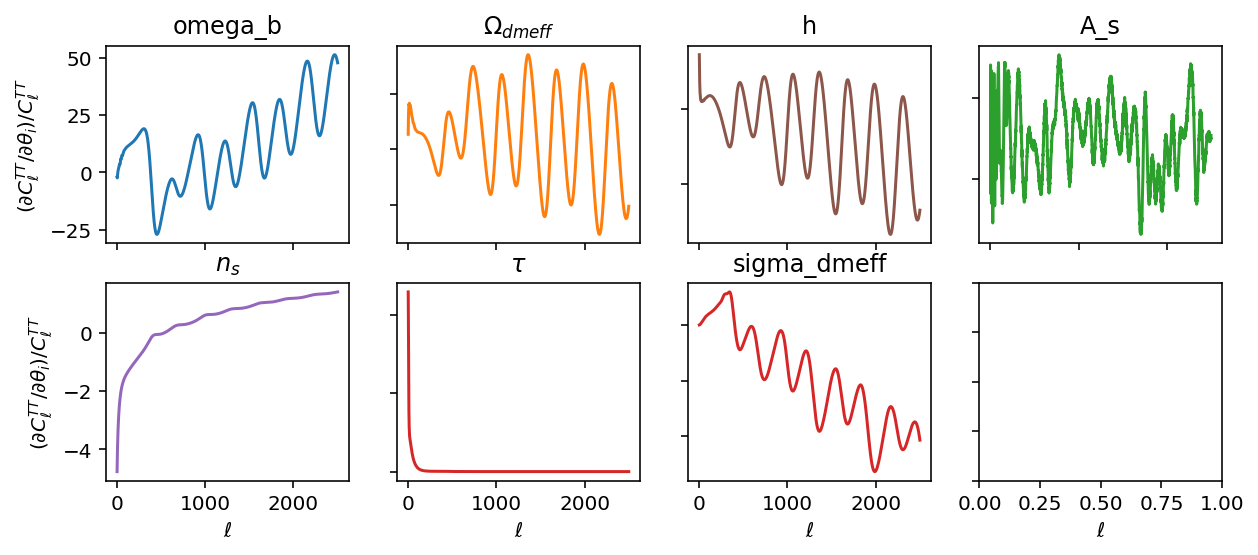

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10,4))

axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')

axs[0, 1].plot(dict_norm_der['omega_dmeff'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmeff}$')

axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')

axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')

axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')

axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')

axs[1, 2].plot(dict_norm_der['sigma_dmeff'], 'tab:red')
axs[1, 2].set_title('sigma_dmeff')

for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#fig.savefig("fisher_plots/derivative_C_l_TT_10GeV_n=2_S4.png")


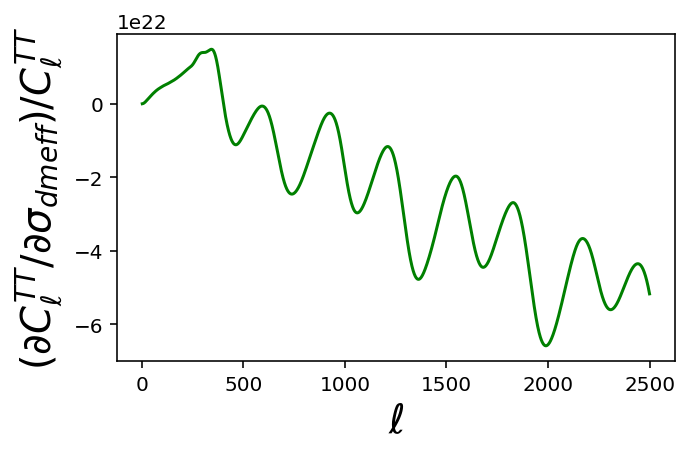

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(ell, dict_norm_der['sigma_dmeff'],'g-',label="hi")
plt.ylabel(r'$(\partial C_{\ell}^{TT} / \partial \sigma_{dmeff}) / C_{\ell}^{TT}$',size=20)
plt.xlabel(r'$\ell$',size=20)
plt.show()

In [11]:
#Noise:
import fishchips.experiments
def noise_Planck_Pol(l_max = 2500): 
    exper = fishchips.experiments.get_PlanckPol_combine()
    Nltt = np.concatenate((exper[0].noise_T, exper[1].noise_T[31:], exper[2].noise_T[101:]))[:l_max+1]
    Nlee = np.concatenate((exper[1].noise_P, exper[2].noise_P[101:]))[:l_max+1]
    Nlkk = fishchips.cmb_lensing.CMB_Lensing_Only().noise_k[:l_max+1]    
    return np.array([Nltt, Nlee, Nlkk])
def noise_CMB_S4(l_max = 2500):
    exper = fishchips.experiments.get_S4()
    Nltt = exper[1].noise_T[:l_max+1]
    Nlee = np.concatenate((exper[0].noise_P, exper[1].noise_P[301:3001], exper[2].noise_P[3001:]))[:l_max+1]
    Nlkk = fishchips.experiments.get_S4_Lensing_Only().noise_k[:l_max+1]   
    return np.array([Nltt, Nlee, Nlkk])

In [12]:
l_max = 2500
exper = fishchips.experiments.get_S4()
Nltt = exper[1].noise_T[:l_max+1]
Nlee = np.concatenate((exper[0].noise_P, exper[1].noise_P[301:3001], exper[2].noise_P[3001:]))[:l_max+1]
Nlkk = fishchips.experiments.get_S4_Lensing_Only().noise_k[:l_max+1]

ModuleNotFoundError: No module named 'orphics'

In [12]:
sT = (1. * (np.pi/60./180. ))/(1.0e6*Tcmb)
sP = (1. * (np.pi/60./180. ))/(1.0e6*Tcmb)
f_sky = 0.4
theta_fwhm = 1.5 * (np.pi/60./180.)

l_min = 2
l_max = 2500

from scipy.special import expit

N_TT = np.zeros(l_max+1, 'float64')
N_EE = np.zeros(l_max+1, 'float64')

for l in range(l_min , l_max+1):
            N_TT[l] = 0
            N_TT[l] += sT**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_TT[l] = 1/N_TT[l]
            N_EE[l] = 0
            N_EE[l] += sP**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_EE[l] = 1/N_EE[l]
N_TT[ell < l_min] = 1e100
N_TT[ell > l_max] = 1e100
N_EE[ell < l_min] = 1e100
N_EE[ell > l_max] = 1e100

In [42]:
N_TT = Nltt / ((1.0e6*Tcmb)**2)
N_EE = Nlee / ((1.0e6*Tcmb)**2)
N_kk = Nlkk / ((1.0e6*Tcmb)**2)

NameError: name 'Nlkk' is not defined

We need:
 
$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$
[Wu et al. 2014](https://arxiv.org/abs/1402.4108)


Computing $C_l$ only using temperature power spectrum for planck baseline. 

$$ \mathbf{C}_{\ell} \equiv 
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)
 $$

Let :
$$   \mathbf{Q}^{i}_{nm} =\, \left( {C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \right)  =
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} \\
  \end{array} } \right)^{-1}
   \left( {\begin{array}{cc}
    \frac{\partial C_{\ell}^{TT}}{\partial \theta_i } & \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } \\
   \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } &\frac{\partial C_{\ell}^{EE}}{\partial \theta_i } \\
  \end{array} } \right)
$$
So that:
$$  F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left[  \mathbf{Q}_{i}  \mathbf{Q}_{j} \right]
$$

In [15]:
MAT_d_cl = [ [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial)]
            , [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial)] ]

<ipython-input-6-2287dab9b5cf>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [41]:
MAT_cl = [
    [fiducial['tt'] + N_TT, fiducial['te'], 0], 
    [fiducial['te'], fiducial['ee'] + N_EE, 0],
    [0, 0, fiducial['pp'] +N_kk]
        ]

NameError: name 'N_kk' is not defined

In [40]:
matrix = [
    [1, fiducial['te']], 
    [fiducial['te'], fiducial['ee'] + N_EE]
        ]
print(matrix)

[[1, 2], [3, 4]]


In [17]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l]], [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l]]]
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l]], [MAT_cl[1][0][l], MAT_cl[1][1][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [18]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)

In [19]:
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 4.603770990911539e-05
omega_dmeff 0.0010214026365722227
h 0.0036318078913446248
A_s 5.8942156751669865e-09
n_s 0.003950033357534356
tau_reio 1.3423110689391502
sigma_dmeff 9.617536507671595e-26


In [20]:
#file = open("sigma_dmeff.txt", "w")
#print("sigma_dmeff","dm_mass [GeV]", sigma_ii*2.48 ,file=file)
#print(sigma_ii, dm_mass,file=file)

In [21]:
#print(dm_mass, sigma_ii*2.48)

generating new axis
['omega_b', 'omega_dmeff', 'h', 'A_s', 'n_s', 'tau_reio', 'sigma_dmeff']


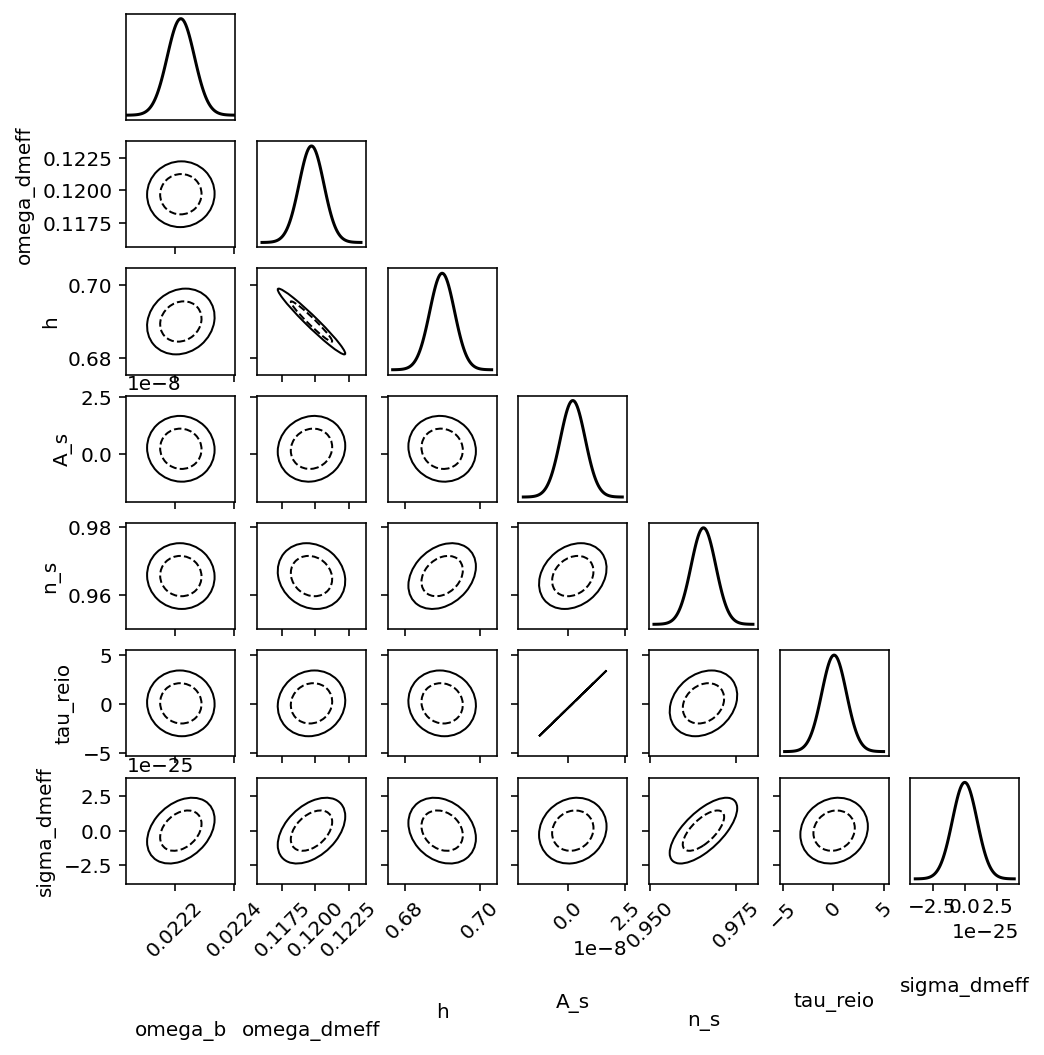

In [22]:
import fishchips.util

cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);

#fig.savefig("fisher_plots/triagular_ellipses_10GeV_n=2_S4.png")

In [23]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48)

In [24]:
print(dat)

('n-power=', 0.0, 'dm_mass=', 1.0, 'stepsize =', 2e-26, 'fisher matrix =', [[3254821597.4414897, -838306367.4832996, -224435335.82785437, 1.987457137511774e+16, 56872780.38792174, -87286387.622704, -9.33155102041297e+29], [-838306367.4832996, 376317777.5210661, 97753486.7480184, -4324831839111542.5, -9203444.628961641, 18992789.65242693, -3.309756660253896e+29], [-224435335.82785437, 97753486.7480184, 25769641.004880562, -893987584900951.0, -2217648.5272851847, 3926138.734192234, -9.52032692384518e+28], [1.9874571375117736e+16, -4324831839111542.0, -893987584900950.9, 5.047588710781903e+23, 1003701356471680.5, -2216678496194901.5, -3.7882392098169285e+37], [56872780.38792174, -9203444.628961641, -2217648.5272851847, 1003701356471680.5, 2441068.590823148, -4408012.369654335, -9.129238470901337e+28], [-87286387.622704, 18992789.652426925, 3926138.734192233, -2216678496194901.5, -4408012.369654335, 9734675.640540149, 1.6636921040110147e+29], [-9.33155102041297e+29, -3.309756660253896e+29,

In [48]:
outF = open("fisher_data/S4_n=2/1GeV.txt", "w")
for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()